**1. Import necessary packages and load csv files**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

**2. Data pre-processing**

In [3]:
#missing values
print(train_df.isnull().sum())
print("----------------------------------------------------")
print(test_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
#fill item "Embarked" in train dataframe
print(train_df.Embarked.value_counts())
train_df[train_df['Embarked'].isnull()]

S    644
C    168
Q     77
Name: Embarked, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


I cannot simply fillna with mode 'S'. I need a more creditable proof.

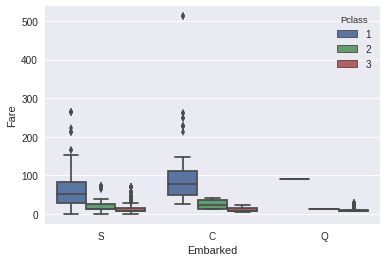

In [5]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=train_df)

I know that these two guys paid 80.0 and they were in Pclass 1.  And from the box-plot, the blue box in group 'C' has a median around 80. So I'll fillna with 'C' instead of the mode 'S'.

In [6]:
#fillna
train_df['Embarked'] = train_df['Embarked'].fillna('C')

In [7]:
#fill item 'Fare' in test dataframe
print(test_df['Fare'].describe())
test_df[test_df['Fare'].isnull()]

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Since item 'Fare' is a numeric variable, so I have to fillna with median or mean.

In [8]:
fare_mean = test_df[(test_df['Pclass'] == 3) & (test_df['Embarked'] == 'S')]['Fare'].mean()
fare_median = test_df[(test_df['Pclass'] == 3) & (test_df['Embarked'] == 'S')]['Fare'].median()
print(test_df[(test_df['Pclass'] == 3) & (test_df['Embarked'] == 'S')]['Fare'].describe())
print('Mean:%d'%fare_mean)
print('Median:%d'%fare_median)

count    141.000000
mean      13.913030
std       12.744667
min        3.170800
25%        7.854200
50%        8.050000
75%       14.500000
max       69.550000
Name: Fare, dtype: float64
Mean:13
Median:8


From the describe, I decide to choose the median. Because the 50%-quantile is 8.05 and the 75%-quantile is 14.5, but the maximum is 69.55. That means some huge numbers affect the mean. So the median is more apt.

In [9]:
#fillna with median
test_df['Fare'] = test_df['Fare'].fillna(fare_median)

And I find that there are too many missing values in  item 'Cabin' which makes it become a useless feature. I haven't got a good way to fill it so I will give up this item in the future prediction.

In [10]:
import re
def get_title(name):
    pattern=re.compile('^.*, (.*?)\..*$',re.S)
    pear=re.findall(pattern,name)
    return pear[0]

train_df['Title'] = train_df['Name'].apply(get_title)
test_df['Title'] = test_df['Name'].apply(get_title)

print(train_df.Title.value_counts())
print("--------------------------------------------------")
print(test_df.Title.value_counts())

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Jonkheer          1
the Countess      1
Don               1
Lady              1
Mme               1
Capt              1
Sir               1
Ms                1
Name: Title, dtype: int64
--------------------------------------------------
Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64


Here is the value counts, it would be wise to divide them into 5 groups.

In [11]:
def group_title(title):
    
    group_men=['Mr','Don','Sir','Master']# return 1
    group_younger_women=['Mlle','Miss','Ms']# return 2
    group_elder_women=['Lady','Mrs','Mme','Dona'] # return 3
    group_army=['Major','Col','Capt']# return 4
    # else return 5 
    
    if title in group_men:
        return 1
    elif title in group_younger_women:
        return 2
    elif title in group_elder_women:
        return 3
    elif title in group_army:
        return 4
    else:
        return 5
    
train_df['TitGroup'] = train_df['Title'].apply(group_title)
test_df['TitGroup'] = test_df['Title'].apply(group_title)

Thanks to  [Titanic best working Classifier](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier) by Sina.  I have a good way to fillna with age.

In [12]:
datasets = [train_df,test_df]

for dataset in datasets:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
    dataset['Age'] = pd.cut(dataset['Age'],5,labels=[i for i in range(1,6)])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


After filling missing values, I have to select features and do standardization.

In [13]:
def class_gender(sex):
    if sex=='male':
        return 1
    else:
        return 2
    
def class_embarked(emb):
    if emb=='S':
        return 1
    if emb=='C':
        return 2
    else:
        return 3

for dataset in datasets:
    #create new column family
    dataset['Family'] = dataset['SibSp']+dataset['Parch']
    #standardization z-score
    dataset['StdFare'] = dataset['Fare'].apply(lambda x:(x-dataset['Fare'].mean())/dataset['Fare'].std())
    #label
    dataset['Sex'] = dataset['Sex'].map(class_gender)
    dataset['Embarked'] = dataset['Embarked'].map(class_embarked)    
    
    
    

In [14]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TitGroup,Family,StdFare
0,1,0,3,"Braund, Mr. Owen Harris",1,2,1,0,A/5 21171,7.2500,NaN,1,Mr,1,1,-0.502163
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,3,1,0,PC 17599,71.2833,C85,2,Mrs,3,1,0.786404
2,3,1,3,"Heikkinen, Miss. Laina",2,2,0,0,STON/O2. 3101282,7.9250,NaN,1,Miss,2,0,-0.488580
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,3,1,0,113803,53.1000,C123,1,Mrs,3,1,0.420494
4,5,0,3,"Allen, Mr. William Henry",1,3,0,0,373450,8.0500,NaN,1,Mr,1,0,-0.486064


In [15]:
numeric_feature = ['Age','Family','StdFare']
def make_dataset(dataset):
    dummy_df = pd.get_dummies(dataset['Pclass'],prefix='Pclass')
    for item in ['Sex','Embarked','TitGroup']:
        new_df = pd.get_dummies(dataset[item],prefix=item)
        dummy_df = pd.concat([dummy_df,new_df],axis = 1)
        
    return pd.concat([dataset[numeric_feature],dummy_df],axis = 1)
    
X_train = make_dataset(train_df)
Y_train = train_df['Survived']
X_test = make_dataset(test_df)

In [16]:
from sklearn.cross_validation import train_test_split
#cross validation
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X_train,Y_train,test_size=0.3,random_state=0)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
#Logistic Regression
def lr_classify(Xtrain,Xtest,Ytrain,Ytest):
    from sklearn.linear_model import LogisticRegression
    
    clf = LogisticRegression(C=1e5)
    clf.fit(Xtrain,Ytrain)
    score = clf.score(Xtest,Ytest)
    print("LinearRegression score: {0}".format(score))

In [18]:
#knn
def knn_classify(Xtrain,Xtest,Ytrain,Ytest):
    from sklearn.neighbors import KNeighborsClassifier
    
    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(Xtrain,Ytrain)
    score = clf.score(Xtest,Ytest)
    print("Knn score: {0}".format(score))

In [19]:
#Random Forest
def rf_classify(Xtrain,Xtest,Ytrain,Ytest):
    from sklearn.ensemble import RandomForestClassifier
    
    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(Xtrain,Ytrain)
    score = clf.score(Xtest,Ytest)
    print("RandomForest score: {0}".format(score))

In [20]:
#NaiveBayes GaussianNB
def nb_classify(Xtrain,Xtest,Ytrain,Ytest):
    from sklearn.naive_bayes import GaussianNB
    
    clf = GaussianNB()
    clf.fit(Xtrain,Ytrain)
    score = clf.score(Xtest,Ytest)
    print("GaussianNB score: {0}".format(score))

In [21]:
#SVM
def svm_classify(Xtrain,Xtest,Ytrain,Ytest):
    from sklearn import svm
    
    clf = svm.SVC()
    clf.fit(Xtrain,Ytrain)
    score = clf.score(Xtest,Ytest)
    print("SVM score: {0}".format(score))

In [22]:
#xgboost
def xgb_classify(Xtrain,Xtest,Ytrain,Ytest):
    import xgboost as xgb
    
    clf = xgb.XGBClassifier()
    clf.fit(Xtrain,Ytrain)
    score = clf.score(Xtest,Ytest)
    print("Xgboost score: {0}".format(score))

In [23]:
#Voting class
def voting_classify(Xtrain,Xtest,Ytrain,Ytest):
    from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier,RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    
    clf1 = GradientBoostingClassifier(n_estimators=200)
    clf2 = RandomForestClassifier(random_state=0,n_estimators=50)
    clf3 = LogisticRegression(random_state=1)
    clf4 = GaussianNB()
    
    clf = VotingClassifier(estimators=[('gbdt',clf1),('rf',clf2),('lr',clf3),('nb',clf4)],voting='soft')
    clf.fit(Xtrain,Ytrain)
    score = clf.score(Xtest,Ytest)
    print("Voting score: {0}".format(score))

In [24]:
lr_classify(Xtrain,Xtest,Ytrain,Ytest)
knn_classify(Xtrain,Xtest,Ytrain,Ytest)
rf_classify(Xtrain,Xtest,Ytrain,Ytest)
nb_classify(Xtrain,Xtest,Ytrain,Ytest)
svm_classify(Xtrain,Xtest,Ytrain,Ytest)
voting_classify(Xtrain,Xtest,Ytrain,Ytest)

LinearRegression score: 0.8208955223880597
Knn score: 0.8059701492537313
RandomForest score: 0.8283582089552238
GaussianNB score: 0.7798507462686567
SVM score: 0.8059701492537313


Voting score: 0.8097014925373134


In [25]:
from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
    
clf1 = GradientBoostingClassifier(n_estimators=200)
clf2 = RandomForestClassifier(random_state=0,n_estimators=50)
clf3 = LogisticRegression(random_state=1)
clf4 = GaussianNB()
    
clf = VotingClassifier(estimators=[('gbdt',clf1),('rf',clf2),('lr',clf3),('nb',clf4)],voting='soft')
clf.fit(X_train,Y_train)
predictions = clf.predict(X_test)

In [28]:
result = pd.DataFrame({'PassengerId':test_df['PassengerId'].as_matrix(),'Survived':predictions})
result.to_csv('svc.csv',index=False)

In [31]:
df = pd.read_csv('svc.csv')
df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
